# Data 102: Final Project Code #
## American Partisanship in Relation to National Attention and Citizen Engagement ##

First, we load in all the necessary Python packages for analysis.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import statsmodels.api as sm
!pip install causalinference
from causalinference import CausalModel

  Using cached CausalInference-0.1.3-py3-none-any.whl (51 kB)


## Data Cleaning ##
We begin by loading in the first table from the US census data (population and voter turnout data), cleaning up the strings and converting relevant columns to integers.

In [2]:
voting = pd.read_csv('table01.csv')
voting.columns = voting.iloc[1]
voting = voting.iloc[3:439, :]
voting.columns.values[1] = 'state_ab'
voting.columns.values[2] = 'state_name'
voting.columns.values[3] = 'district'
voting.columns.values[4] = 'num_votes_cast'
voting['num_votes_cast'] = pd.to_numeric(voting['num_votes_cast'].str.replace(',', '').str.replace('-', '0'))
voting.columns.values[5] = 'voting_pop'
voting['voting_pop'] = pd.to_numeric(voting['voting_pop'].str.replace(',', ''))
voting.columns.values[7] = 'voting_percent'
voting['voting_percent'] = pd.to_numeric(voting['voting_percent'].str.replace('-', '0'))/100
voting = voting[['state_ab', 'state_name', 'district', 'num_votes_cast', 'voting_pop', 'voting_percent']]
voting = voting.reset_index().drop(columns='index')
voting.columns.name = None
voting.head()

,state_ab,state_name,district,num_votes_cast,voting_pop,voting_percent
0,AL,Alabama,1,242617,544464,0.446
1,AL,Alabama,2,226230,516295,0.438
2,AL,Alabama,3,231915,543854,0.426
3,AL,Alabama,4,230969,515701,0.448
4,AL,Alabama,5,260673,551968,0.472


We then load in the next census table (age distributions of districts) and clean it up as well.

In [3]:
age = pd.read_csv('table02a.csv')
age.columns = age.iloc[1]
age = age.iloc[4:440, [1, 2, 3, 6, 8, 10, 12, 14, 16, 18, 20]]
age.columns.values[0] = 'state_ab'
age.columns.values[1] = 'state_name'
age.columns.values[2] = 'district'
age.columns.values[3] = '18-29_pop'
age.columns.values[4] = '18-29_percent'
age.columns.values[5] = '30-44_pop'
age.columns.values[6] = '30-44_percent'
age.columns.values[7] = '45-64_pop'
age.columns.values[8] = '45-64_percent'
age.columns.values[9] = '65_plus_pop'
age.columns.values[10] = '65_plus_percent'
for col in ['18-29_pop', '30-44_pop', '45-64_pop', '65_plus_pop']:
    age[col] = pd.to_numeric(age[col].str.replace(',', ''))
for col in ['18-29_percent', '30-44_percent', '45-64_percent', '65_plus_percent']:
    age[col] = pd.to_numeric(age[col])/100
age = age.reset_index().drop(columns='index')
age.columns.name = None
age.head()

,state_ab,state_name,district,18-29_pop,18-29_percent,30-44_pop,30-44_percent,45-64_pop,45-64_percent,65_plus_pop,65_plus_percent
0,AL,Alabama,1,104060,0.191,125900,0.231,188031,0.345,126473,0.232
1,AL,Alabama,2,109222,0.212,118999,0.230,173351,0.336,114723,0.222
2,AL,Alabama,3,121328,0.223,121212,0.223,182379,0.335,118935,0.219
3,AL,Alabama,4,95990,0.186,114921,0.223,177247,0.344,127543,0.247
4,AL,Alabama,5,109986,0.199,129788,0.235,193348,0.350,118846,0.215


Next we load in the census table on sex and poverty and clean it up.

In [4]:
sex_poverty = pd.read_csv('table02b.csv')
sex_poverty.columns = sex_poverty.iloc[1]
sex_poverty = sex_poverty.iloc[4:440, [1, 2, 3, 6, 8, 10, 12, 16, 18]]
sex_poverty.columns.values[0] = 'state_ab'
sex_poverty.columns.values[1] = 'state_name'
sex_poverty.columns.values[2] = 'district'
sex_poverty.columns.values[3] = 'men_pop'
sex_poverty.columns.values[4] = 'men_percent'
sex_poverty.columns.values[5] = 'women_pop'
sex_poverty.columns.values[6] = 'women_percent'
sex_poverty.columns.values[7] = 'poverty_pop'
sex_poverty.columns.values[8] = 'poverty_percent'
for col in ['men_pop', 'women_pop', 'poverty_pop']:
    sex_poverty[col] = pd.to_numeric(sex_poverty[col].str.replace(',', ''))
for col in ['men_percent', 'women_percent', 'poverty_percent']:
    sex_poverty[col] = pd.to_numeric(sex_poverty[col])/100
sex_poverty = sex_poverty.reset_index().drop(columns='index')
sex_poverty.columns.name = None
sex_poverty.head()

,state_ab,state_name,district,men_pop,men_percent,women_pop,women_percent,poverty_pop,poverty_percent
0,AL,Alabama,1,256603,0.471,287861,0.529,76483,0.144
1,AL,Alabama,2,243971,0.473,272324,0.527,75815,0.152
2,AL,Alabama,3,261066,0.480,282788,0.520,88748,0.169
3,AL,Alabama,4,248166,0.481,267535,0.519,70775,0.139
4,AL,Alabama,5,267633,0.485,284335,0.515,61196,0.114


The next table is about education distributions in each US district.

In [5]:
education = pd.read_csv('table02c.csv')
education.columns = education.iloc[1]
education = education.iloc[4:440, [1, 2, 3, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]]
education.columns.values[0] = 'state_ab'
education.columns.values[1] = 'state_name'
education.columns.values[2] = 'district'
education.columns.values[3] = 'less_9th_pop'
education.columns.values[4] = 'less_9th_percent'
education.columns.values[5] = '9th-12th_pop'
education.columns.values[6] = '9th-12th_percent'
education.columns.values[7] = 'high_school_pop'
education.columns.values[8] = 'high_school_percent'
education.columns.values[9] = 'some_college_pop'
education.columns.values[10] = 'some_college_percent'
education.columns.values[11] = 'associates_pop'
education.columns.values[12] = 'associates_percent'
education.columns.values[13] = 'bachelors_pop'
education.columns.values[14] = 'bachelors_percent'
education.columns.values[15] = 'graduate_pop'
education.columns.values[16] = 'graduate_percent'
for col in ['less_9th_pop', '9th-12th_pop', 'high_school_pop', 'some_college_pop', 'associates_pop', 'bachelors_pop', 'graduate_pop']:
    education[col] = pd.to_numeric(education[col].str.replace(',', ''))
for col in ['less_9th_percent', '9th-12th_percent', 'high_school_percent', 'some_college_percent', 'associates_percent', 'bachelors_percent', 'graduate_percent']:
    education[col] = pd.to_numeric(education[col])/100
education = education.reset_index().drop(columns='index')
education.columns.name = None
education.head()

,state_ab,state_name,district,less_9th_pop,less_9th_percent,9th-12th_pop,9th-12th_percent,high_school_pop,high_school_percent,some_college_pop,some_college_percent,associates_pop,associates_percent,bachelors_pop,bachelors_percent,graduate_pop,graduate_percent
0,AL,Alabama,1,13409,0.025,57234,0.105,185503,0.341,122236,0.225,42603,0.078,82971,0.152,40508,0.074
1,AL,Alabama,2,18295,0.035,53192,0.103,172427,0.334,119350,0.231,45677,0.088,69082,0.134,38272,0.074
2,AL,Alabama,3,19578,0.036,56833,0.105,174209,0.320,142705,0.262,45713,0.084,63916,0.118,40900,0.075
3,AL,Alabama,4,24346,0.047,57850,0.112,175806,0.341,121739,0.236,51436,0.100,52697,0.102,31827,0.062
4,AL,Alabama,5,14908,0.027,43805,0.079,151609,0.275,123272,0.223,45097,0.082,113417,0.205,59860,0.108


Lastly, we load in data on race distributions and clean it up.

In [6]:
race = pd.read_csv('table02d.csv')
race.columns = race.iloc[1]
race = race.iloc[4:440, [1, 2, 3, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36]]
race.columns.values[0] = 'state_ab'
race.columns.values[1] = 'state_name'
race.columns.values[2] = 'district'
race.columns.values[3] = 'white_pop'
race.columns.values[4] = 'white_percent'
race.columns.values[5] = 'black_pop'
race.columns.values[6] = 'black_percent'
race.columns.values[7] = 'asian_pop'
race.columns.values[8] = 'asian_percent'
race.columns.values[9] = 'amer_indian_pop'
race.columns.values[10] = 'amer_indian_percent'
race.columns.values[11] = 'nat_hawaiian_pop'
race.columns.values[12] = 'nat_hawaiian_percent'
race.columns.values[13] = 'other_race_pop'
race.columns.values[14] = 'other_race_percent'
race.columns.values[15] = 'two_more_race_pop'
race.columns.values[16] = 'two_more_race_percent'
race.columns.values[17] = 'hispanic_pop'
race.columns.values[18] = 'hispanic_percent'
for col in ['white_pop', 'black_pop', 'asian_pop', 'amer_indian_pop', 'nat_hawaiian_pop', 'other_race_pop', 'two_more_race_pop', 'hispanic_pop']:
    race[col] = pd.to_numeric(race[col].str.replace('N', '0').str.replace(',', ''))
for col in ['white_percent', 'black_percent', 'asian_percent', 'amer_indian_percent', 'nat_hawaiian_percent', 'other_race_percent', 'two_more_race_percent', 'hispanic_percent']:
    race[col] = pd.to_numeric(race[col].str.replace('N', '0'))/100
race = race.reset_index().drop(columns='index')
race.columns.name = None
race.head()

,state_ab,state_name,district,white_pop,white_percent,black_pop,black_percent,asian_pop,asian_percent,amer_indian_pop,amer_indian_percent,nat_hawaiian_pop,nat_hawaiian_percent,other_race_pop,other_race_percent,two_more_race_pop,two_more_race_percent,hispanic_pop,hispanic_percent
0,AL,Alabama,1,379018,0.696,144187,0.265,6506,0.012,0,0.0,0,0.0,2884,0.005,7325,0.013,11678,0.021
1,AL,Alabama,2,338162,0.655,162707,0.315,3817,0.007,0,0.0,0,0.0,1818,0.004,7705,0.015,9755,0.019
2,AL,Alabama,3,390539,0.718,139026,0.256,4028,0.007,0,0.0,0,0.0,2448,0.005,6754,0.012,12241,0.023
3,AL,Alabama,4,459105,0.890,39714,0.077,0,0.000,0,0.0,0,0.0,3529,0.007,8327,0.016,11700,0.023
4,AL,Alabama,5,427462,0.774,99160,0.180,5209,0.009,0,0.0,0,0.0,5852,0.011,12317,0.022,14670,0.027


Finally, we merge together all the census data to get population data on all 435 US congressional districts.

In [7]:
census_data = pd.merge(left = voting, right = age, how = 'inner', on = ['state_ab', 'state_name', 'district'])
census_data = pd.merge(left = census_data, right = sex_poverty, how = 'inner', on = ['state_ab', 'state_name', 'district'])
census_data = pd.merge(left = census_data, right = education, how = 'inner', on = ['state_ab', 'state_name', 'district'])
census_data = pd.merge(left = census_data, right = race, how = 'inner', on = ['state_ab', 'state_name', 'district'])
census_data.head()

,state_ab,state_name,district,num_votes_cast,voting_pop,voting_percent,18-29_pop,18-29_percent,30-44_pop,30-44_percent,...,amer_indian_pop,amer_indian_percent,nat_hawaiian_pop,nat_hawaiian_percent,other_race_pop,other_race_percent,two_more_race_pop,two_more_race_percent,hispanic_pop,hispanic_percent
0,AL,Alabama,1,242617,544464,0.446,104060,0.191,125900,0.231,...,0,0.0,0,0.0,2884,0.005,7325,0.013,11678,0.021
1,AL,Alabama,2,226230,516295,0.438,109222,0.212,118999,0.230,...,0,0.0,0,0.0,1818,0.004,7705,0.015,9755,0.019
2,AL,Alabama,3,231915,543854,0.426,121328,0.223,121212,0.223,...,0,0.0,0,0.0,2448,0.005,6754,0.012,12241,0.023
3,AL,Alabama,4,230969,515701,0.448,95990,0.186,114921,0.223,...,0,0.0,0,0.0,3529,0.007,8327,0.016,11700,0.023
4,AL,Alabama,5,260673,551968,0.472,109986,0.199,129788,0.235,...,0,0.0,0,0.0,5852,0.011,12317,0.022,14670,0.027


Now, we start looking at the FiveThirtyEight data on endorsements. We load in the table on Democratic primary candidates and keep the relevant endorsement columns. Then we group by district to have a row for each district.

In [8]:
dem_candidates = pd.read_csv('dem_candidates.csv')
dem_candidates = dem_candidates[dem_candidates['Office Type'] == 'Representative']
dem_candidates = dem_candidates.drop(dem_candidates.columns[[0, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]], axis = 1)
dem_districts = dem_candidates.groupby(by = ['State', 'District', 'Partisan Lean']).agg(np.any).reset_index()
dem_districts['District'] = dem_districts['District'].str.replace('[^0-9]', '', regex=True)
dem_districts.head()

,State,District,Partisan Lean,Emily Endorsed?,Guns Sense Candidate?,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?
0,AL,1,-30.680000,False,False,False,False,False,False,False,False,False,False,False,False
1,AL,2,-33.080002,False,False,False,False,False,False,False,False,False,False,False,False
2,AL,3,-33.660000,False,True,False,False,False,False,False,False,False,False,False,False
3,AL,4,-62.480000,False,True,False,False,False,False,False,False,False,False,False,False
4,AL,5,-34.830002,False,False,False,False,False,False,False,False,True,False,False,False


Next, we load in the table on Republican primary candidates, clean it up, and group by district.

In [9]:
rep_candidates = pd.read_csv('rep_candidates.csv', encoding = 'latin-1')
rep_candidates = rep_candidates[rep_candidates['Office Type'] == 'Representative']
rep_candidates = rep_candidates.drop(rep_candidates.columns[[0, 3, 4, 5, 6, 7, 8, 9, 10, 11]], axis = 1)
rep_districts = rep_candidates.groupby(by = ['State', 'District']).agg(np.any).reset_index()
rep_districts['District'] = rep_districts['District'].str.replace('[^0-9]', '', regex=True)
rep_districts.head()

,State,District,Trump Endorsed?,Bannon Endorsed?,Great America Endorsed?,NRA Endorsed?,Right to Life Endorsed?,Susan B. Anthony Endorsed?,Club for Growth Endorsed?,Koch Support?,House Freedom Support?,Tea Party Endorsed?,Main Street Endorsed?,Chamber Endorsed?,No Labels Support?
0,AZ,1,False,False,False,False,False,False,True,False,False,True,False,False,False
1,AZ,2,False,False,False,False,False,False,False,True,False,False,False,False,False
2,AZ,3,False,False,False,False,False,False,False,False,False,False,False,False,False
3,AZ,8,False,False,False,False,False,True,False,True,True,False,False,False,False
4,AZ,9,False,False,False,False,False,False,False,False,False,False,False,False,False


Now we perform an outer merge on the districts with Democratic primaries and districts with Republican primaries to include as many districts as possible.

In [10]:
district_data = pd.merge(left = dem_districts, right = rep_districts, on = ['State', 'District'], how = 'outer')
district_data.head()

,State,District,Partisan Lean,Emily Endorsed?,Guns Sense Candidate?,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,...,NRA Endorsed?,Right to Life Endorsed?,Susan B. Anthony Endorsed?,Club for Growth Endorsed?,Koch Support?,House Freedom Support?,Tea Party Endorsed?,Main Street Endorsed?,Chamber Endorsed?,No Labels Support?_y
0,AL,1,-30.680000,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AL,2,-33.080002,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AL,3,-33.660000,False,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AL,4,-62.480000,False,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AL,5,-34.830002,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, we make the groupings of endorsements as outlined in the report. We set a cell to True if any candidate in that district received an endorsement from an organization/person within that group.

In [11]:
district_data['any_endorse'] = district_data.iloc[:, 3:].sum(1) > 0
district_data['gun_org_endorse'] = district_data[['NRA Endorsed?', 'Guns Sense Candidate?']].sum(1) > 0
district_data['abortion_org_endorse'] = district_data[['Susan B. Anthony Endorsed?', 'Right to Life Endorsed?', 'Emily Endorsed?']].sum(1) > 0
district_data['left_figure_endorse'] = district_data[['Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?']].sum(1) > 0
district_data['right_figure_endorse'] = district_data[['Trump Endorsed?', 'Bannon Endorsed?']].sum(1) > 0
district_data['political_figure_endorse'] = district_data['left_figure_endorse'] + district_data['right_figure_endorse']
district_data['prog_org_endorse'] = district_data[['Our Revolution Endorsed?', 'Justice Dems Endorsed?', 'PCCC Endorsed?', 'Indivisible Endorsed?', 'WFP Endorsed?']].sum(1) > 0
district_data['cons_org_endorse'] = district_data[['Great America Endorsed?', 'Club for Growth Endorsed?', 'Koch Support?', 'House Freedom Support?', 'Tea Party Endorsed?', 'Main Street Endorsed?']].sum(1) > 0
district_endorsements = district_data[['State', 'District', 'Partisan Lean', 'any_endorse', 'gun_org_endorse', 'abortion_org_endorse', 'left_figure_endorse', 'right_figure_endorse', 'political_figure_endorse', 'prog_org_endorse', 'cons_org_endorse']]
district_endorsements = district_endorsements.rename(columns = {'State' : 'state_ab', 'District': 'district', 'Partisan Lean' : 'partisan_lean'})
district_endorsements['district'] = district_endorsements['district'].replace('', '1')
district_endorsements.head()

,state_ab,district,partisan_lean,any_endorse,gun_org_endorse,abortion_org_endorse,left_figure_endorse,right_figure_endorse,political_figure_endorse,prog_org_endorse,cons_org_endorse
0,AL,1,-30.680000,False,False,False,False,False,False,False,False
1,AL,2,-33.080002,False,False,False,False,False,False,False,False
2,AL,3,-33.660000,True,True,False,False,False,False,False,False
3,AL,4,-62.480000,True,True,False,False,False,False,False,False
4,AL,5,-34.830002,True,False,False,False,False,False,True,False


Now we load in the FiveThirtyEight data on partisan lean for all districts and clean it up.

In [12]:
partisan_raw = pd.read_csv('fivethirtyeight_partisan_lean_DISTRICTS.csv')
partisan_data = pd.DataFrame(partisan_raw['district'].str.split('-').to_list(), columns=['state_ab', 'district'])
partisan_data['abs_partisan_lean'] = partisan_raw['2018'].str.replace('[^.0-9]', '', regex=True).astype(float)
partisan_data.head()

,state_ab,district,abs_partisan_lean
0,AK,1,15.21
1,AL,1,28.61
2,AL,2,30.97
3,AL,3,31.37
4,AL,4,59.81


We then merge the absolute partisan lean column into the district-level endorsements dataset.

In [13]:
district_partisan = pd.merge(left = district_endorsements, right = partisan_data, on = ['state_ab', 'district'], how = 'inner')
district_partisan = district_partisan.drop(columns = 'partisan_lean')
abs_partisan_lean = district_partisan.pop('abs_partisan_lean')
district_partisan.insert(2, 'abs_partisan_lean', abs_partisan_lean)
district_partisan.head()

,state_ab,district,abs_partisan_lean,any_endorse,gun_org_endorse,abortion_org_endorse,left_figure_endorse,right_figure_endorse,political_figure_endorse,prog_org_endorse,cons_org_endorse
0,AL,1,28.61,False,False,False,False,False,False,False,False
1,AL,2,30.97,False,False,False,False,False,False,False,False
2,AL,3,31.37,True,True,False,False,False,False,False,False
3,AL,4,59.81,True,True,False,False,False,False,False,False
4,AL,5,32.81,True,False,False,False,False,False,True,False


Finally, we merge the census dataset with the endorsements/partisan lean dataset.

In [14]:
district_full = pd.merge(left = district_partisan, right = census_data, on = ['state_ab', 'district'], how = 'left')
district_full['district'] = district_full['district'].replace('', '1')
state_name = district_full.pop('state_name')
district_full.insert(0, 'state_name', state_name)
district_full.head()

,state_name,state_ab,district,abs_partisan_lean,any_endorse,gun_org_endorse,abortion_org_endorse,left_figure_endorse,right_figure_endorse,political_figure_endorse,...,amer_indian_pop,amer_indian_percent,nat_hawaiian_pop,nat_hawaiian_percent,other_race_pop,other_race_percent,two_more_race_pop,two_more_race_percent,hispanic_pop,hispanic_percent
0,Alabama,AL,1,28.61,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,2884.0,0.005,7325.0,0.013,11678.0,0.021
1,Alabama,AL,2,30.97,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,1818.0,0.004,7705.0,0.015,9755.0,0.019
2,Alabama,AL,3,31.37,True,True,False,False,False,False,...,0.0,0.0,0.0,0.0,2448.0,0.005,6754.0,0.012,12241.0,0.023
3,Alabama,AL,4,59.81,True,True,False,False,False,False,...,0.0,0.0,0.0,0.0,3529.0,0.007,8327.0,0.016,11700.0,0.023
4,Alabama,AL,5,32.81,True,False,False,False,False,False,...,0.0,0.0,0.0,0.0,5852.0,0.011,12317.0,0.022,14670.0,0.027


## EDA ##

In [15]:
data = district_full

In the following sections of code, we create various visualizations for our EDA section.

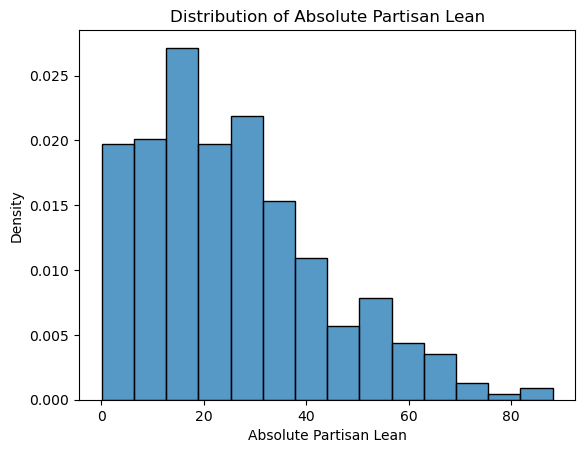

In [16]:
sns.histplot(data = data, x = 'abs_partisan_lean', stat = 'density')
plt.xlabel("Absolute Partisan Lean")
plt.title('Distribution of Absolute Partisan Lean')
plt.show()

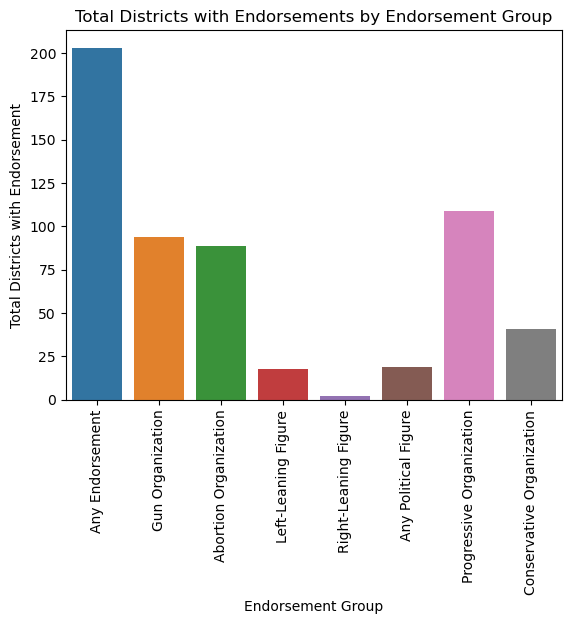

In [17]:
g1 = data['any_endorse'].values.sum()
g2 = data['gun_org_endorse'].values.sum()
g3 = data['abortion_org_endorse'].values.sum()
g4 = data['left_figure_endorse'].values.sum()
g5 = data['right_figure_endorse'].values.sum()
g6 = data['political_figure_endorse'].values.sum()
g7 = data['prog_org_endorse'].values.sum()
g8 = data['cons_org_endorse'].values.sum()

names = ['Any Endorsement',
         'Gun Organization',
         'Abortion Organization',
         'Left-Leaning Figure',
         'Right-Leaning Figure',
         'Any Political Figure',
         'Progressive Organization',
         'Conservative Organization']
endorsements = [g1, g2, g3, g4, g5, g6, g7, g8]

sns.barplot(x = names, y = endorsements)
plt.xlabel("Endorsement Group")
plt.xticks(rotation = 90)
plt.ylabel('Total Districts with Endorsement')
plt.title('Total Districts with Endorsements by Endorsement Group')

plt.show()

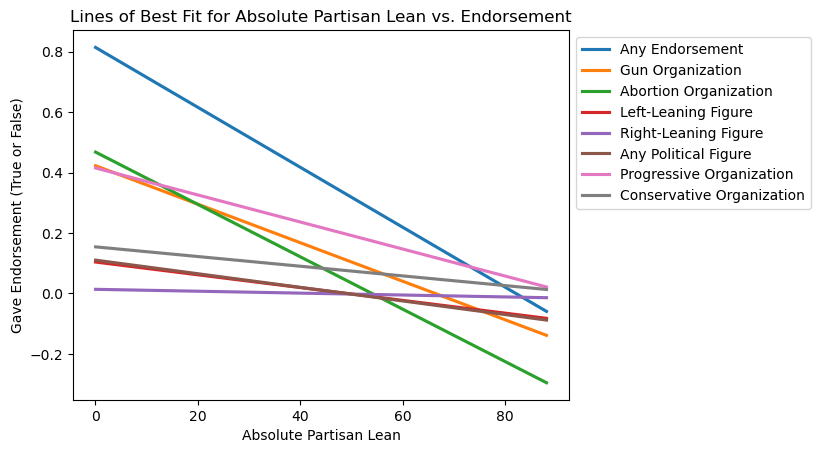

In [18]:
groups = ['any_endorse',
         'gun_org_endorse',
         'abortion_org_endorse',
         'left_figure_endorse',
         'right_figure_endorse',
         'political_figure_endorse',
         'prog_org_endorse',
         'cons_org_endorse']
for i in np.arange(len(endorsements)):
    sns.regplot(data = data, x ='abs_partisan_lean', y = groups[i], scatter = False, ci = False, label = names[i])
plt.xlabel('Absolute Partisan Lean')
plt.ylabel('Gave Endorsement (True or False)')
plt.title('Lines of Best Fit for Absolute Partisan Lean vs. Endorsement')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

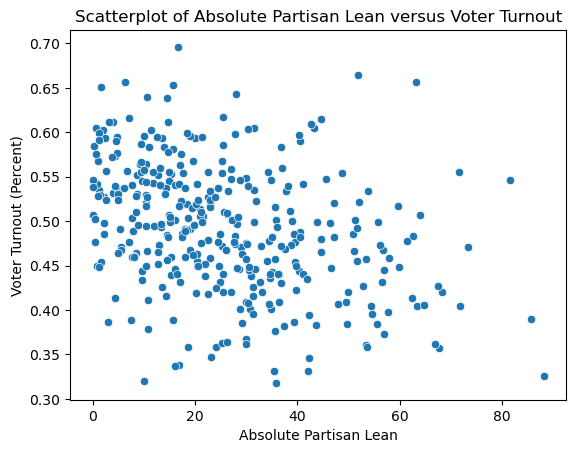

In [19]:
voter_turn_out = data[data['voting_percent'] > 0]
sns.scatterplot(data = voter_turn_out, x = 'abs_partisan_lean', y = 'voting_percent')
plt.xlabel('Absolute Partisan Lean')
plt.ylabel('Voter Turnout (Percent)')
plt.title('Scatterplot of Absolute Partisan Lean versus Voter Turnout')
plt.show()

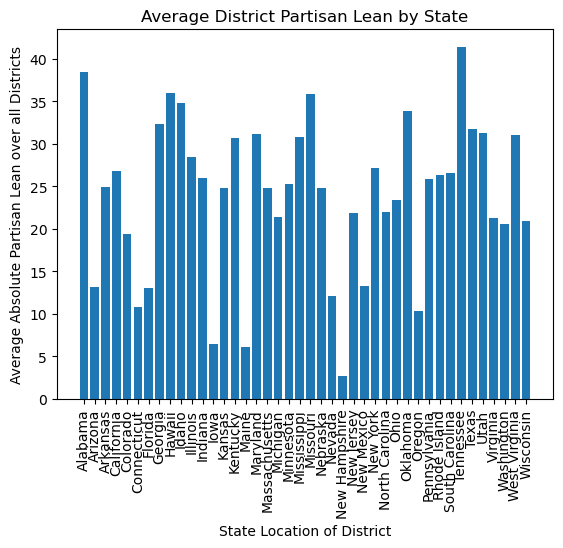

In [20]:
stated = data.groupby(['state_name'], as_index=False).mean()
plt.bar(stated['state_name'], stated['abs_partisan_lean'])
plt.xlabel("State Location of District")
plt.xticks(rotation = 90)
plt.ylabel('Average Absolute Partisan Lean over all Districts')
plt.title('Average District Partisan Lean by State')
plt.show()

/tmp/ipykernel_41/52667240.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_data['categorical_lean'] = categorical_lean


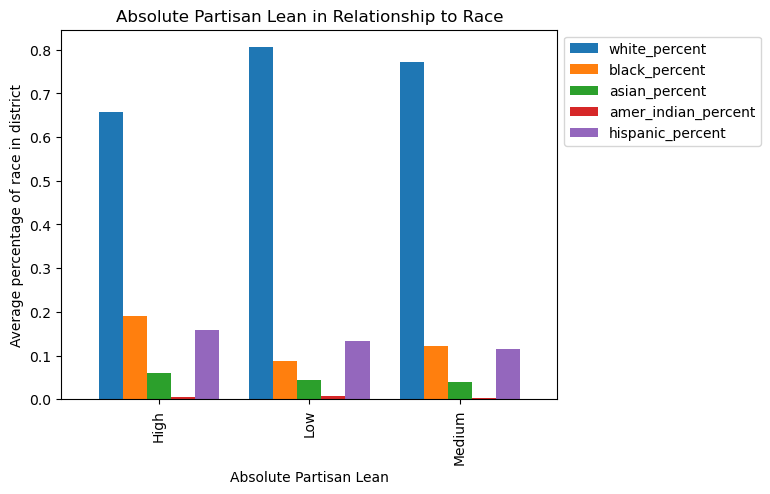

In [21]:
race_data = data[['abs_partisan_lean','white_percent','black_percent','asian_percent','amer_indian_percent','hispanic_percent']]

#cycle through data and make categories
categorical_lean = []
for i in race_data['abs_partisan_lean']:
    if i > 40:
        categorical_lean.append('High')
    elif i > 20:
        categorical_lean.append('Medium')
    else:
        categorical_lean.append('Low')
race_data['categorical_lean'] = categorical_lean
grouped_table = race_data.groupby('categorical_lean').mean().drop(['abs_partisan_lean'], axis = 1)

grouped_table.plot(kind = 'bar', width = 0.8)
plt.ylabel('Average percentage of race in district')
plt.xlabel('Absolute Partisan Lean')
plt.title('Absolute Partisan Lean in Relationship to Race')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

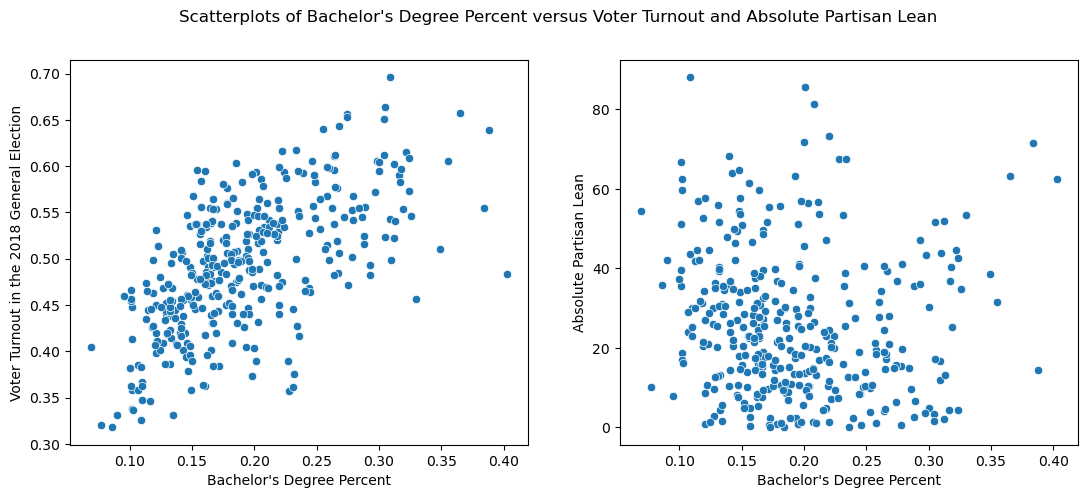

In [22]:
fig, ax = plt.subplots(1,2, figsize = (13 , 5))
sns.scatterplot(data = voter_turn_out, x = 'bachelors_percent', y = 'voting_percent', ax = ax[0])
sns.scatterplot(data = voter_turn_out, x = 'bachelors_percent', y = 'abs_partisan_lean', ax = ax[1])
fig.suptitle("Scatterplots of Bachelor's Degree Percent versus Voter Turnout and Absolute Partisan Lean")
ax[0].set(xlabel ="Bachelor's Degree Percent", ylabel = "Voter Turnout in the 2018 General Election")
ax[1].set(xlabel ="Bachelor's Degree Percent", ylabel = "Absolute Partisan Lean")
plt.show()

## Research Question 1 ##

First we calculate the relevant correlations and p-values for each group.

In [23]:
correlations = dict(zip(groups, np.zeros(len(groups))))
p_values = dict(zip(groups, np.zeros(len(groups))))
for group in groups:
    correlations[group], p_values[group] = pearsonr(data['abs_partisan_lean'], data[group])

In [24]:
correlations

{'any_endorse': -0.3537265288303834,
 'gun_org_endorse': -0.2576598538885909,
 'abortion_org_endorse': -0.35672035866423635,
 'left_figure_endorse': -0.1724802021863193,
 'right_figure_endorse': -0.07520707064228685,
 'political_figure_endorse': -0.17902926866717725,
 'prog_org_endorse': -0.17273087107848376,
 'cons_org_endorse': -0.0896063556351526}

In [25]:
p_values

{'any_endorse': 3.869916590840938e-12,
 'gun_org_endorse': 6.477077722951401e-07,
 'abortion_org_endorse': 2.4738746476030977e-12,
 'left_figure_endorse': 0.0009681662127108682,
 'right_figure_endorse': 0.15272535710215238,
 'political_figure_endorse': 0.0006104499876722638,
 'prog_org_endorse': 0.0009515058513075095,
 'cons_org_endorse': 0.08823676709502899}

Then we define a function to print the rejected hypotheses for a given $\alpha$ for a naive approach, then with the Bonferroni correction and Benjamini-Hochberg procedure.

In [26]:
def p_value_correction(alpha):
    naive_rejections = [group for group in p_values.keys() if p_values[group] < alpha]
    print("Naive rejections:")
    print(*naive_rejections, sep = ", ")
    bonferroni_rejections = [group for group in p_values.keys() if p_values[group] < (alpha/len(groups))]
    print("Bonferroni rejections:")
    print(*bonferroni_rejections, sep = ", ")
    #B-H correction
    sorted_p = sorted(p_values.values())
    m = len(groups)
    k = np.arange(1, m+1)
    threshold = max([sorted_p[i] for i in np.arange(0, m) if sorted_p[i] <= k[i] * (alpha/m)])
    b_h_rejections = [group for group in p_values.keys() if p_values[group] <= threshold]
    print("B-H rejections:")
    print(*b_h_rejections, sep = ", ")

In [27]:
p_value_correction(0.05)

Naive rejections:
any_endorse, gun_org_endorse, abortion_org_endorse, left_figure_endorse, political_figure_endorse, prog_org_endorse
Bonferroni rejections:
any_endorse, gun_org_endorse, abortion_org_endorse, left_figure_endorse, political_figure_endorse, prog_org_endorse
B-H rejections:
any_endorse, gun_org_endorse, abortion_org_endorse, left_figure_endorse, political_figure_endorse, prog_org_endorse


## Research Question 2 ##

First we bring in the OLS regressor from class, define the explanatory variables, and output the regression results.

In [28]:
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)
explanatory_variables = list(data.columns[16:-1][::2])
explanatory_variables.append('abs_partisan_lean')
print('Explanatory variables:')
print(*explanatory_variables, sep = ", ")
data = data.fillna(0)
model = fit_OLS_model(data, 'voting_percent', explanatory_variables, intercept = True)
print(model.summary())

Explanatory variables:
18-29_percent, 30-44_percent, 45-64_percent, 65_plus_percent, men_percent, women_percent, poverty_percent, less_9th_percent, 9th-12th_percent, high_school_percent, some_college_percent, associates_percent, bachelors_percent, graduate_percent, white_percent, black_percent, asian_percent, amer_indian_percent, nat_hawaiian_percent, other_race_percent, two_more_race_percent, abs_partisan_lean
                            OLS Regression Results                            
Dep. Variable:         voting_percent   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     54.29
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           3.53e-97
Time:                        11:21:39   Log-Likelihood:                 613.92
No. Observations:                 363   AIC:                            -1182.
Df Residuals:                   

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Here, we create the bins for "high" absolute partisan lean vs. "normal" lean.

In [29]:
data['high_partisan_lean'] = pd.cut(data['abs_partisan_lean'], bins = [0, 40, 90], labels = [False, True])

We remove absolute partisan lean from our list of explanatory variables to create a list of only confounders.

In [30]:
confounders = explanatory_variables
confounders.remove('abs_partisan_lean')

We define a model using the `causalinference` package, have it estimate propensity scores, trim any scores less than 0.1 and more than 0.9, then have it estimate the average treatment effect.

In [31]:
causal = CausalModel(Y = data['voting_percent'].values, D = data['high_partisan_lean'].values, X = data[confounders].values)
causal.est_propensity_s()
causal.trim()
causal.est_via_weighting()
print(causal.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.006      0.008      0.685      0.493     -0.010      0.022



/opt/conda/lib/python3.9/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


We also use the approach from class, taking our propensity scores and feeding them into the IPW formula we learned.

In [32]:
data['pscore'] = causal.propensity['fitted']
data_trimmed = data[(data['pscore'] > 0.1) & (data['pscore'] < 0.9)]
n = data_trimmed.shape[0]
treated = data_trimmed[data_trimmed['high_partisan_lean']==True]
control = data_trimmed[data_trimmed['high_partisan_lean']==False]
trimmed_ipw_estimate = (1/n)*sum(treated['voting_percent']/treated['pscore']) - (1/n)*sum(control['voting_percent']/(1-control['pscore']))
print('Estimated ATE for high partisan lean on voting rate:')
print(trimmed_ipw_estimate)

Estimated ATE for high partisan lean on voting rate:
0.009817790802396809


We create a confidence interval for this ATE using a formula found online (bootstrapping proved to take too long to run).

In [33]:
standard_error = np.sqrt(sum(data_trimmed['pscore']**2)/n)/np.sqrt(n)
lower_bound = trimmed_ipw_estimate - 1.96 * standard_error
upper_bound = trimmed_ipw_estimate + 1.96 * standard_error
print('Confidence interval of ATE')
print('(' + str(lower_bound) + ', ' + str(upper_bound) + ')')

Confidence interval of ATE
(-0.05544770802688631, 0.07508328963167993)
